In [2]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam
import matplotlib.pyplot as plt
import pickle

from game import *
from agents import *
from checkers import *

In [3]:
activation_fn = lambda x: 1/(1+np.exp(-x))
# activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

width = [128,64]
hidden_layers = len(width)
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

n_features = 33+32
feature_func = combined_features

# n_features = 34
# feature_func = checkers_features_augmented

# n_features = 12
# feature_func = checkers_features_simple

# n_features = 32
# feature_func = raw_board_features

reward_function = checkers_reward
# reward_function = raw_reward

max_moves = 500

weight_shape = mlp = MLP(architecture).weights.shape
np.random.seed(12)
initial_weights = np.random.normal(0,0.01,size=weight_shape)


first_agent = SarsaLearningAgent_MLP(architecture, feature_func, n_features, reward_function = reward_function, 
                                     alpha=initial_alpha, gamma=gamma, epsilon=initial_epsilon, 
                                     is_learning_agent=False, weights=initial_weights)




ab1 = AlphaBetaAgent(1)
ab2 = AlphaBetaAgent(2)
ab3 = AlphaBetaAgent(3)
rand_agent = RandomAgent()

max_moves = 500
gamma = 0.7
initial_alpha = 0.001
initial_epsilon = 0.5
quiet = True

first_agent_turn = True
rules = ClassicGameRules(max_moves=max_moves)
game = rules.new_game(first_agent, rand_agent, first_agent_turn, quiet=quiet)
num_moves, game_state = game.run()
print('Oppn: Rand agent, RL agent play first', 'win =',game_state.is_first_agent_win(),'draw =',game_state.max_moves_done, 'moves =', num_moves)

first_agent_turn = False
rules = ClassicGameRules(max_moves=max_moves)
game = rules.new_game(first_agent, rand_agent, first_agent_turn, quiet=quiet)
num_moves, game_state = game.run()
print('Oppn: Rand agent, RL agent play second', 'win =',game_state.is_first_agent_win(),'draw =',game_state.max_moves_done, 'moves =', num_moves)


first_agent_turn = True
rules = ClassicGameRules(max_moves=max_moves)
game = rules.new_game(first_agent, ab1, first_agent_turn, quiet=quiet)
num_moves, game_state = game.run()
print('Oppn: AB1, RL agent play first', 'win =',game_state.is_first_agent_win(),'draw =',game_state.max_moves_done,'moves =', num_moves)


first_agent_turn = False
rules = ClassicGameRules(max_moves=max_moves)
game = rules.new_game(first_agent, ab1, first_agent_turn, quiet=quiet)
num_moves, game_state = game.run()
print('Oppn: AB1, RL agent play second', 'win =',game_state.is_first_agent_win(),'draw =',game_state.max_moves_done, 'moves =', num_moves)


    

Oppn: Rand agent, RL agent play first win = False draw = False moves = 30
Oppn: Rand agent, RL agent play second win = False draw = False moves = 43
Oppn: AB1, RL agent play first win = False draw = False moves = 48
Oppn: AB1, RL agent play second win = False draw = False moves = 33


In [4]:
n_train_games = 2000
n_decay = 10
n_games_test = 10
test_frequency = 10
max_random_start_depth_train = 3
max_random_start_depth_test = 3
gamma = 0.7
initial_alpha = 0.001
initial_epsilon = 0.5
random_prob = 0.2

first_agent = SarsaLearningAgent_MLP(architecture, feature_func, n_features, reward_function = reward_function, 
                                     alpha=initial_alpha, gamma=gamma, epsilon=initial_epsilon, 
                                     is_learning_agent=True, weights=initial_weights)

second_agent_list = [ab1, ab2, ab3, rand_agent]
all_results = []
all_draws = []
all_oppn_idx = []
all_weights = []
all_rewards = []
all_num = []
test_results_rand = []
test_results_1 = []
test_results_2 = []
test_results_3 = []
test_draws_rand = []
test_draws_1 = []
test_draws_2 = []
test_draws_3 = []

for n in range(n_train_games):
    
    # change alpha and epsilon after n_decay games
    if n%n_decay == n_decay-1:
        first_agent.alpha = max([0.95*first_agent.alpha, 1e-4])
        first_agent.epsilon = max([0.95*first_agent.epsilon, 0.01])
        print(n, 'Fraction of wins = ', np.mean(all_results[-n_decay:]), 'Fraction of draws = ', np.mean(all_draws[-n_decay:]))
        print(n ,'alpha = ',first_agent.alpha, 'epsilon = ',first_agent.epsilon)
    
    if n%100 == 0: print(n)
    # train against randomly selected agent
    first_agent_turn = bool(np.random.binomial(1,0.5))
    
    second_agent_idx = np.random.choice(len(second_agent_list))  
    all_oppn_idx.append(second_agent_idx)
    second_agent = second_agent_list[second_agent_idx]
#     second_agent = ab3
    
    rules = ClassicGameRules(max_moves=max_moves)
    game = rules.new_game(first_agent, second_agent, first_agent_turn, quiet=quiet)    
    
    # random start
    for _ in range(np.random.choice(max_random_start_depth_train)*2):
        possible_moves = game.game_state.board.get_possible_next_moves()
        next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
        game.game_state.board.make_move(next_move, switch_player_turn=True)
        
    num_moves, game_state = game.run(random_prob = random_prob)
    
    all_num.append(num_moves)
    all_rewards.append(first_agent.episode_rewards)
    all_results.append(game_state.is_first_agent_win())
    all_draws.append((game_state.max_moves_done))
#     all_weights.append(first_agent.nn.weights.copy())
        
    if n%test_frequency == 0:
#         print(n)
        
        all_weights.append(first_agent.nn.weights.copy())
        
        this_test_results_rand = []
        this_test_results_1 = []
        this_test_results_2 = []
        this_test_results_3 = []
        
        this_test_draws_rand = []
        this_test_draws_1 = []
        this_test_draws_2 = []
        this_test_draws_3 = []
        
        for n in range(n_games_test):
            current_epislon = first_agent.epsilon
            test_agent = SarsaLearningAgent_MLP(architecture, feature_func, n_features, reward_function = reward_function,
                                                alpha=0.0, gamma=gamma, epsilon=current_epislon, 
                                                is_learning_agent=True, weights=all_weights[-1])

            # play against ab1
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, ab1, first_agent_turn, quiet=quiet)
            
            # random start
            random_start_spots = game.game_state.board.spots
            for _ in range(np.random.choice(max_random_start_depth_test)*2):
                possible_moves = game.game_state.board.get_possible_next_moves()
                next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
                game.game_state.board.make_move(next_move, switch_player_turn=True)
                random_start_spots = game.game_state.board.spots
        
            num_moves, game_state = game.run(random_prob = random_prob)
            this_test_results_1.append(game_state.is_first_agent_win())
            this_test_draws_1.append(game_state.max_moves_done)
            
            # play against ab2
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, ab2, first_agent_turn, quiet=quiet)
            game.game_state.board.spots = random_start_spots # set start board position to the same random start
            num_moves, game_state = game.run(random_prob = random_prob)
            this_test_results_2.append(game_state.is_first_agent_win())
            this_test_draws_2.append(game_state.max_moves_done)
            
            # play against ab3
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, ab3, first_agent_turn, quiet=quiet)
            game.game_state.board.spots = random_start_spots # set start board position to the same random start
            num_moves, game_state = game.run(random_prob = random_prob)
            this_test_results_3.append(game_state.is_first_agent_win())
            this_test_draws_3.append(game_state.max_moves_done)
            
            # play against random agent
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet)
            game.game_state.board.spots = random_start_spots # set start board position to the same random start
            num_moves, game_state = game.run(random_prob = random_prob)
            this_test_results_rand.append(game_state.is_first_agent_win())
            this_test_draws_rand.append(game_state.max_moves_done)
            
        test_results_1.append(np.mean(np.array(this_test_results_1)))
        test_results_2.append(np.mean(np.array(this_test_results_2)))
        test_results_3.append(np.mean(np.array(this_test_results_3)))
        test_results_rand.append(np.mean(np.array(this_test_results_rand)))
        
        test_draws_1.append(np.mean(np.array(this_test_draws_1)))
        test_draws_2.append(np.mean(np.array(this_test_draws_2)))
        test_draws_3.append(np.mean(np.array(this_test_draws_3)))
        test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))
        
        print('wins = ',test_results_1[-1],test_results_2[-1],test_results_3[-1],test_results_rand[-1])    
        print('draws = ',test_draws_1[-1],test_draws_2[-1],test_draws_3[-1],test_draws_rand[-1])    

0
wins =  0.4 0.0 0.0 0.8
draws =  0.0 0.0 0.0 0.0
9 Fraction of wins =  0.2222222222222222 Fraction of draws =  0.0
9 alpha =  0.00095 epsilon =  0.475
wins =  0.9 0.0 0.1 0.7
draws =  0.0 0.0 0.0 0.0
19 Fraction of wins =  0.3 Fraction of draws =  0.0
19 alpha =  0.0009025 epsilon =  0.45125
wins =  0.2 0.0 0.0 0.6
draws =  0.0 0.0 0.0 0.0
29 Fraction of wins =  0.4 Fraction of draws =  0.0
29 alpha =  0.000857375 epsilon =  0.42868749999999994
wins =  0.6 0.0 0.0 0.5
draws =  0.1 0.0 0.0 0.0
39 Fraction of wins =  0.1 Fraction of draws =  0.0
39 alpha =  0.0008145062499999999 epsilon =  0.40725312499999994
wins =  0.4 0.0 0.0 0.7
draws =  0.0 0.0 0.0 0.0
49 Fraction of wins =  0.3 Fraction of draws =  0.0
49 alpha =  0.0007737809374999998 epsilon =  0.38689046874999994
wins =  0.6 0.0 0.2 0.4
draws =  0.1 0.0 0.0 0.0
59 Fraction of wins =  0.2 Fraction of draws =  0.0
59 alpha =  0.0007350918906249997 epsilon =  0.3675459453124999
wins =  0.5 0.0 0.0 0.5
draws =  0.0 0.0 0.0 0.0
69 

500
wins =  0.8 0.1 0.2 1.0
draws =  0.1 0.3 0.0 0.0
509 Fraction of wins =  0.6 Fraction of draws =  0.0
509 alpha =  0.0001 epsilon =  0.03654886325643874
wins =  1.0 0.0 0.0 1.0
draws =  0.0 0.3 0.0 0.0
519 Fraction of wins =  0.3 Fraction of draws =  0.1
519 alpha =  0.0001 epsilon =  0.0347214200936168
wins =  0.8 0.1 0.0 1.0
draws =  0.1 0.3 0.2 0.0
529 Fraction of wins =  0.5 Fraction of draws =  0.1
529 alpha =  0.0001 epsilon =  0.03298534908893595
wins =  0.8 0.1 0.1 1.0
draws =  0.1 0.0 0.1 0.0
539 Fraction of wins =  0.7 Fraction of draws =  0.1
539 alpha =  0.0001 epsilon =  0.03133608163448915
wins =  0.8 0.1 0.1 1.0
draws =  0.1 0.3 0.2 0.0
549 Fraction of wins =  0.4 Fraction of draws =  0.1
549 alpha =  0.0001 epsilon =  0.029769277552764692
wins =  0.8 0.4 0.2 1.0
draws =  0.1 0.4 0.0 0.0
559 Fraction of wins =  0.5 Fraction of draws =  0.1
559 alpha =  0.0001 epsilon =  0.028280813675126457
wins =  0.9 0.3 0.1 0.9
draws =  0.1 0.2 0.1 0.0
569 Fraction of wins =  0.9 

/Users/shihyitseng/anaconda3/envs/am207/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


wins =  0.9 0.2 0.2 0.9
draws =  0.0 0.1 0.1 0.0
879 Fraction of wins =  0.4 Fraction of draws =  0.2
879 alpha =  0.0001 epsilon =  0.01
wins =  0.6 0.3 0.2 0.9
draws =  0.3 0.1 0.1 0.0
889 Fraction of wins =  0.8 Fraction of draws =  0.0
889 alpha =  0.0001 epsilon =  0.01
wins =  1.0 0.0 0.1 0.9
draws =  0.0 0.3 0.0 0.0
899 Fraction of wins =  0.3 Fraction of draws =  0.3
899 alpha =  0.0001 epsilon =  0.01
900
wins =  0.7 0.0 0.2 1.0
draws =  0.0 0.1 0.2 0.0
909 Fraction of wins =  0.4 Fraction of draws =  0.0
909 alpha =  0.0001 epsilon =  0.01
wins =  1.0 0.4 0.3 0.9
draws =  0.0 0.2 0.1 0.0
919 Fraction of wins =  0.6 Fraction of draws =  0.1
919 alpha =  0.0001 epsilon =  0.01
wins =  0.9 0.2 0.1 0.7
draws =  0.1 0.0 0.0 0.0
929 Fraction of wins =  0.3 Fraction of draws =  0.2
929 alpha =  0.0001 epsilon =  0.01
wins =  0.7 0.2 0.1 0.8
draws =  0.1 0.2 0.2 0.0
939 Fraction of wins =  0.7 Fraction of draws =  0.0
939 alpha =  0.0001 epsilon =  0.01
wins =  0.8 0.0 0.0 1.0
draws 

wins =  1.0 0.2 0.2 1.0
draws =  0.0 0.4 0.3 0.0
1469 Fraction of wins =  0.7 Fraction of draws =  0.1
1469 alpha =  0.0001 epsilon =  0.01
wins =  1.0 0.3 0.3 0.9
draws =  0.0 0.0 0.1 0.0
1479 Fraction of wins =  0.6 Fraction of draws =  0.0
1479 alpha =  0.0001 epsilon =  0.01
wins =  0.9 0.2 0.2 0.8
draws =  0.0 0.0 0.1 0.0
1489 Fraction of wins =  0.8 Fraction of draws =  0.1
1489 alpha =  0.0001 epsilon =  0.01
wins =  0.9 0.3 0.3 1.0
draws =  0.1 0.1 0.0 0.0
1499 Fraction of wins =  0.6 Fraction of draws =  0.0
1499 alpha =  0.0001 epsilon =  0.01
1500
wins =  0.9 0.4 0.0 1.0
draws =  0.1 0.1 0.1 0.0
1509 Fraction of wins =  0.5 Fraction of draws =  0.1
1509 alpha =  0.0001 epsilon =  0.01
wins =  0.9 0.2 0.1 0.9
draws =  0.1 0.2 0.1 0.0
1519 Fraction of wins =  0.6 Fraction of draws =  0.1
1519 alpha =  0.0001 epsilon =  0.01
wins =  0.8 0.4 0.2 1.0
draws =  0.2 0.2 0.0 0.0
1529 Fraction of wins =  0.3 Fraction of draws =  0.2
1529 alpha =  0.0001 epsilon =  0.01
wins =  0.9 0.4

/Users/shihyitseng/anaconda3/envs/am207/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


wins =  0.9 0.1 0.0 1.0
draws =  0.1 0.3 0.1 0.0
1879 Fraction of wins =  0.6 Fraction of draws =  0.1
1879 alpha =  0.0001 epsilon =  0.01
wins =  0.8 0.1 0.2 0.9
draws =  0.2 0.0 0.2 0.0
1889 Fraction of wins =  0.5 Fraction of draws =  0.1
1889 alpha =  0.0001 epsilon =  0.01
wins =  0.8 0.1 0.0 0.9
draws =  0.1 0.0 0.0 0.0
1899 Fraction of wins =  0.4 Fraction of draws =  0.1
1899 alpha =  0.0001 epsilon =  0.01
1900
wins =  0.8 0.3 0.3 0.9
draws =  0.1 0.4 0.0 0.0
1909 Fraction of wins =  0.7 Fraction of draws =  0.0
1909 alpha =  0.0001 epsilon =  0.01
wins =  0.6 0.2 0.2 0.9
draws =  0.2 0.2 0.2 0.0
1919 Fraction of wins =  0.5 Fraction of draws =  0.1
1919 alpha =  0.0001 epsilon =  0.01
wins =  0.9 0.3 0.1 1.0
draws =  0.0 0.0 0.3 0.0
1929 Fraction of wins =  0.1 Fraction of draws =  0.1
1929 alpha =  0.0001 epsilon =  0.01
wins =  0.9 0.1 0.0 0.9
draws =  0.0 0.3 0.0 0.0
1939 Fraction of wins =  0.8 Fraction of draws =  0.1
1939 alpha =  0.0001 epsilon =  0.01


/Users/shihyitseng/anaconda3/envs/am207/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)


wins =  0.8 0.3 0.0 1.0
draws =  0.1 0.3 0.3 0.0
1949 Fraction of wins =  0.6 Fraction of draws =  0.1
1949 alpha =  0.0001 epsilon =  0.01
wins =  0.8 0.2 0.1 1.0
draws =  0.2 0.1 0.2 0.0
1959 Fraction of wins =  0.6 Fraction of draws =  0.0
1959 alpha =  0.0001 epsilon =  0.01
wins =  0.6 0.1 0.0 0.9
draws =  0.3 0.1 0.3 0.0
1969 Fraction of wins =  0.5 Fraction of draws =  0.1
1969 alpha =  0.0001 epsilon =  0.01
wins =  0.7 0.2 0.0 0.8
draws =  0.2 0.3 0.2 0.0
1979 Fraction of wins =  0.6 Fraction of draws =  0.0
1979 alpha =  0.0001 epsilon =  0.01
wins =  0.8 0.0 0.1 0.9
draws =  0.0 0.2 0.3 0.0
1989 Fraction of wins =  0.5 Fraction of draws =  0.1
1989 alpha =  0.0001 epsilon =  0.01
wins =  0.9 0.3 0.1 1.0
draws =  0.1 0.3 0.1 0.0
1999 Fraction of wins =  0.5 Fraction of draws =  0.1
1999 alpha =  0.0001 epsilon =  0.01


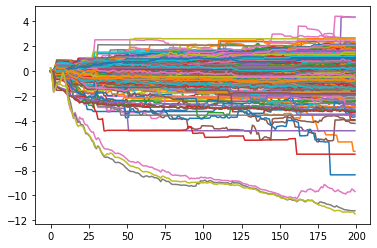

In [5]:
all_weights_array = np.stack(all_weights)
np.squeeze(all_weights_array).shape
plt.plot(np.squeeze(all_weights_array)[:,::20]);

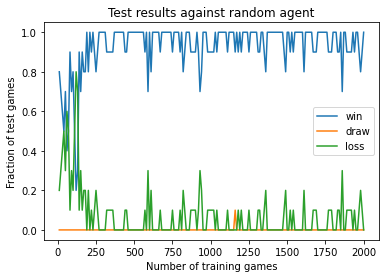

In [6]:
loss_rand = 1-np.array(test_results_rand)-np.array(test_draws_rand)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_rand,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_rand,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_rand,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against random agent');

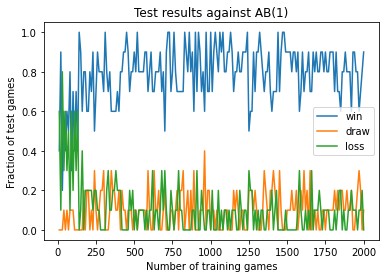

In [7]:
loss_1 = 1-np.array(test_results_1)-np.array(test_draws_1)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_1,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_1,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_1,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(1)');

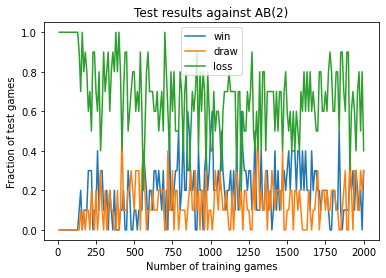

In [8]:
loss_2 = 1-np.array(test_results_2)-np.array(test_draws_2)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_2,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_2,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_2,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(2)');

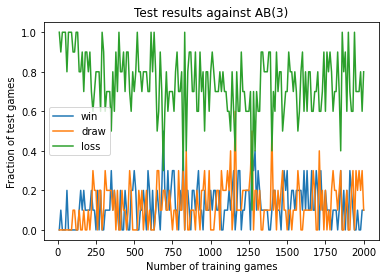

In [9]:
loss_3 = 1-np.array(test_results_3)-np.array(test_draws_3)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_3,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_3,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_3,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(3)');

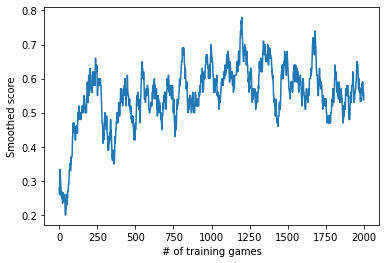

In [10]:
w = 50
calib = np.convolve(np.ones(n_train_games), np.ones(w), 'same')
all_score = 1*np.array(all_results) + 0.5*np.array(all_draws)
mean_smooth_score = np.convolve(all_score, np.ones(w), 'same') / calib
plt.plot(mean_smooth_score)
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');

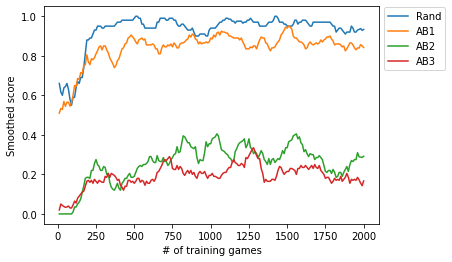

In [11]:
w = 10
calib = np.convolve(np.ones(len(test_results_rand)), np.ones(w), 'same')
all_score_rand = 1*np.array(test_results_rand) + 0.5*np.array(test_draws_rand)
all_score_1 = 1*np.array(test_results_1) + 0.5*np.array(test_draws_1)
all_score_2 = 1*np.array(test_results_2) + 0.5*np.array(test_draws_2)
all_score_3 = 1*np.array(test_results_3) + 0.5*np.array(test_draws_3)
mean_smooth_score_rand = np.convolve(all_score_rand, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_rand, label='Rand')
mean_smooth_score_1 = np.convolve(all_score_1, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_1, label='AB1')
mean_smooth_score_2 = np.convolve(all_score_2, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_2,label='AB2')
mean_smooth_score_3 = np.convolve(all_score_3, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_3,label='AB3')
plt.legend(bbox_to_anchor=(1,1.02))
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');

In [12]:
import pickle

data = {'all_results':all_results,
        'all_draws':all_draws,
        'all_oppn_idx':all_oppn_idx,
        'all_weights':all_weights,
        'all_num':all_num,
        'all_rewards':all_rewards,
        'test_results_rand':test_results_rand,
        'test_results_1':test_results_1,
        'test_results_2':test_results_2,
        'test_results_3':test_results_3,
        'test_draws_rand':test_draws_rand,
        'test_draws_1':test_draws_1,
        'test_draws_2':test_draws_2,
        'test_draws_3':test_draws_3}
with open(r"SARSA_with_MLP_raw_board_plus_33_features_checker_reward_mix_oppn_rand_prob_02.pkl", "wb") as f:
    pickle.dump(data, f)